## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [39]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [40]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [41]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [42]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [43]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [44]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [45]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [46]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [47]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [48]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [49]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [50]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ AGENT CHUYÊN MÔN (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================

# --- HÀM plan_delegator_agent GIỮ NGUYÊN TỪ GIẢI PHÁP TRƯỚC ---
# (Dán lại hàm plan_delegator_agent đã sửa ở lần trước vào đây)
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v9.7 - Tư duy Linh hoạt) đang triển khai Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    reflection_notes = state.get('reflection_notes')

    replan_prompt_part = ""
    if reflection_notes and "Tổng thời gian" in reflection_notes:
        print_warning(f"Nhận được yêu cầu làm lại kế hoạch từ Compiler: {reflection_notes}")
        replan_prompt_part = f"""
        **MỆNH LỆNH TỪ VÒNG LẶP TRƯỚC:**
        "{reflection_notes}"
        Kế hoạch trước đã thất bại vì TỔNG THỜI GIAN vượt quá giới hạn.
        **HƯỚNG DẪN SỬA LỖI:**
        Khi tạo danh sách nhiệm vụ mới, hãy **giảm thời lượng** của các hoạt động, đặc biệt là các hoạt động luyện tập, để đảm bảo tổng thời gian cộng lại **KHÔNG VƯỢỢT QUÁ {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút**. Đây là ưu tiên hàng đầu.
        """

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Trợ lý Sư phạm, chuyên viên thực thi kế hoạch một cách chính xác và linh hoạt.
    **NHIỆM VỤ:** Dựa vào **Bản thiết kế Sư phạm**, hãy chuyển đổi nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".

    {replan_prompt_part}

    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN CẦN TUÂN THỦ):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **ƯU TIÊN MỆNH LỆNH:** Nếu có `MỆNH LỆNH TỪ VÒNG LẶP TRƯỚC`, hãy tuân thủ nó.
    2.  **BÁM SÁT KỊCH BẢN:** Mỗi giai đoạn trong bản thiết kế phải được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập.
    3.  **PHÂN BỔ THỜI GIAN HỢP LÝ:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút cho tất cả các nhiệm vụ.
    4.  **QUY TẮC HOẠT ĐỘNG ĐỆM (RẤT QUAN TRỌNG):** Nhiệm vụ cuối cùng của kế hoạch **PHẢI** là một hoạt động 'Vận dụng và Củng cố'. Trong `task_description` của nhiệm vụ này, hãy ghi rõ rằng: "Hoạt động này có thể co giãn. Ưu tiên hoàn thành các bài tập cơ bản. Các bài tập nâng cao là phần mở rộng nếu còn thời gian." Điều này giúp giáo viên linh hoạt trong thực tế.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        agent_outputs_history = state.get("agent_outputs", {})
        new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": "Học sinh thực hành các bài tập cơ bản. Phần nâng cao có thể thực hiện nếu còn thời gian.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

# === NÂNG CẤP `Content Validator` THÀNH `Time-Budget Advisor` ===
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        # Xử lý lỗi từ agent chuyên môn
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}

    # Tính toán ngân sách thời gian
    total_allowed_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    agent_outputs = state.get('agent_outputs', {})
    completed_activities = agent_outputs.get('activities', []) + agent_outputs.get('assessments', [])
    time_spent = sum(item.get('duration_minutes', 0) for item in completed_activities)
    time_remaining = total_allowed_duration - time_spent
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm, chuyên gia về phân bổ thời gian và chất lượng nội dung.
    **NGÂN SÁCH THỜI GIAN HIỆN TẠI:**
    - Tổng thời lượng buổi học: {total_allowed_duration} phút.
    - Thời gian đã sử dụng cho các hoạt động trước: {time_spent} phút.
    - **Thời gian còn lại cho TẤT CẢ các hoạt động sau:** {time_remaining} phút.

    **NHIỆM VỤ:** Thẩm định nội dung được tạo ra, đặc biệt chú ý đến sự cân bằng giữa chất lượng và ngân sách thời gian.
    
    **YÊU CẦU GỐC CỦA NHIỆM VỤ:**
    - Tên nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Thời lượng dự kiến: "{current_task.get('estimated_duration', 'N/A')} phút"

    **NỘI DUNG ĐƯỢC TẠO RA CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```

    **CÁC BƯỚC SUY LUẬN:**
    1.  **Kiểm tra Chất lượng:** Nội dung có chính xác về chuyên môn và phù hợp sư phạm không? Nếu không, `is_valid: false`.
    2.  **Kiểm tra Thời gian Nội tại:** Thời lượng `duration_minutes` trong nội dung có hợp lý với các thành phần `core_component` và `extension_component` không?
    3.  **Kiểm tra Ngân sách Toàn cục (QUAN TRỌNG NHẤT):** So sánh `duration_minutes` với `Thời gian còn lại`.
        - Nếu `duration_minutes` chiếm một phần hợp lý của thời gian còn lại (để vẫn còn đủ cho các hoạt động sau), thì nội dung hợp lệ.
        - Nếu `duration_minutes` quá lớn, chiếm gần hết hoặc vượt quá thời gian còn lại, đây là LỖI CẤU TRÚC NGHIÊM TRỌNG.

    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu hoàn toàn hợp lệ: `is_valid: true`, `feedback: "Nội dung hợp lệ."`.
    - Nếu có lỗi nhỏ về thời gian (có thể sửa): `is_valid: false`, `feedback: "[STRUCTURAL_FEEDBACK] Thời gian chưa tối ưu..."`, và **BẮT BUỘC** có `suggested_duration`.
    - Nếu có lỗi lớn về ngân sách thời gian: `is_valid: false`, `feedback: "[STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất ({content.get('duration_minutes')} phút) quá lớn so với thời gian còn lại ({time_remaining} phút). Cần thiết kế lại hoạt động này trong khoảng [X] phút để đảm bảo tiến độ."`, và **BẮT BUỘC** có `suggested_duration` là một con số hợp lý hơn.
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
        else:
            final_feedback = result.feedback
            if result.suggested_duration:
                final_feedback += f" | SUGGESTED_DURATION: {result.suggested_duration}"
            
            print_warning(f"CỐ VẤN PHẢN BIỆN: {final_feedback}")
            return {"validation_feedback": final_feedback, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Time-Budget Advisor: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

# === NÂNG CẤP `Specialist Agents` ĐỂ TẠO HOẠT ĐỘNG LINH HOẠT ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và thực tế.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT** với cấu trúc linh hoạt.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung:** {state.get('student_persona', {}).get('differentiation_strategy', {})}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    - **THỜI GIAN ƯỚC TÍNH (RÀNG BUỘC CHÍNH):** {task_to_run.get('estimated_duration', 10)} phút.

    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **ƯU TIÊN THỜI GIAN:** Tổng thời gian `duration_minutes` phải thực tế và tuân thủ thời gian ước tính.
    2.  **CẤU TRÚC LÕI/MỞ RỘNG:**
        -   **`core_component` (BẮT BUỘC):** Thiết kế phần hoạt động cốt lõi mà tất cả học sinh phải hoàn thành. Phần này nên chiếm khoảng 70-80% tổng thời gian.
        -   **`extension_component` (NẾU PHÙ HỢP):** Thiết kế một hoạt động nhỏ, bài tập thêm, hoặc câu hỏi mở rộng. Phần này là "nếu còn thời gian". Nếu hoạt động quá ngắn hoặc là hoạt động giới thiệu, trường này có thể bỏ trống.
    3.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài rõ ràng trong các thành phần.
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        # Gộp core và extension thành một description chung để tương thích với node trình bày
        content_dict['question_or_description'] = f"**Phần Cốt lõi:**\n{content_dict.get('core_component', '')}\n\n**Phần Mở rộng (nếu còn thời gian):**\n{content_dict.get('extension_component', 'Không có')}"
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (Linh hoạt)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.


In [51]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP & NODE TRÌNH BÀY (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================

async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.7 - Tư duy Linh hoạt) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        reflection = "Kế hoạch thất bại. Không có hoạt động nào được tạo ra. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    # Nếu tổng thời gian hợp lệ, cho qua ngay
    if (allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5):
         print_step(f"CRITIC LỚN: Kế hoạch hợp lệ! Tổng thời gian ({total_duration} phút) nằm trong giới hạn cho phép.")
    # Nếu không, thử "cắt tỉa" hoạt động cuối
    else:
        print_warning(f"CRITIC LỚN: Tổng thời gian ({total_duration} phút) không hợp lệ. Đang thử cắt tỉa hoạt động cuối...")
        
        all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
        last_activity = all_content_sorted[-1]
        
        # Chỉ điều chỉnh nếu hoạt động cuối là hoạt động có thể co giãn
        is_flexible = "vận dụng" in last_activity.get('activity_name', '').lower() or \
                      "luyện tập" in last_activity.get('activity_name', '').lower() or \
                      last_activity.get('extension_component')

        if is_flexible:
            duration_of_last_activity = last_activity.get('duration_minutes', 0)
            duration_of_other_activities = total_duration - duration_of_last_activity
            
            new_duration_for_last = allowed_duration - duration_of_other_activities
            
            if new_duration_for_last >= 5: # Đảm bảo hoạt động cuối không quá ngắn
                print_step(f"Điều chỉnh thành công! Cắt bớt hoạt động cuối từ {duration_of_last_activity} phút xuống còn {new_duration_for_last} phút.")
                last_activity['duration_minutes'] = new_duration_for_last
                # Cập nhật lại mô tả để phản ánh việc cắt bớt
                last_activity['question_or_description'] = f"**Phần Cốt lõi:**\n{last_activity.get('core_component', '')}\n\n**Phần Mở rộng:** (Phần này có thể được bỏ qua do hạn chế về thời gian)"
                # Cập nhật lại danh sách với hoạt động đã được sửa
                all_content_items = all_content_sorted[:-1] + [last_activity]
            else:
                reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) quá dài, không thể cứu vãn. Lập kế hoạch lại từ đầu với thời gian ngắn hơn cho mỗi hoạt động."
                print_warning(f"CRITIC LỚN: {reflection}")
                return {"reflection_notes": reflection}
        else:
            reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ và hoạt động cuối không phải hoạt động linh hoạt. Lập kế hoạch lại."
            print_warning(f"CRITIC LỚN: {reflection}")
            return {"reflection_notes": reflection}

    # --- Phần còn lại giữ nguyên ---
    print_step("Bắt đầu tổng hợp giáo án dạng JSON...")
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.", "Phát triển kỹ năng hợp tác và trình bày." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# --- markdown_presentation_node giữ nguyên ---
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.7) đang tạo bản trình bày Markdown...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}

    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp & Node trình bày (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.")

✅ Agent tổng hợp & Node trình bày (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [52]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def update_task_duration_node(state: "TeacherStateV5") -> Dict[str, Any]:
    """
    Node này thực hiện một "ca phẫu thuật" chính xác vào danh sách nhiệm vụ.
    Nó tìm nhiệm vụ bị lỗi thời gian và cập nhật nó với thời lượng được đề xuất.
    """
    print_step("`Node: Task Time Surgeon`  surgically updating task duration...")
    feedback = state.get("validation_feedback")
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")

    if not all([feedback, task_list, current_task_id is not None]):
        print_warning("Thiếu thông tin để sửa thời gian, bỏ qua.")
        return {}

    # Trích xuất thời gian đề xuất từ feedback
    suggested_duration = None
    try:
        # Sử dụng regex để tìm số theo sau "SUGGESTED_DURATION:"
        match = re.search(r"SUGGESTED_DURATION:\s*(\d+)", feedback)
        if match:
            suggested_duration = int(match.group(1))
            print_step(f"Đã trích xuất thời gian đề xuất: {suggested_duration} phút.")
    except (ValueError, TypeError):
        print_warning("Không thể trích xuất thời gian đề xuất từ feedback.")
        return {"validation_feedback": "Lỗi trích xuất, không thể sửa.", "reflection_notes": feedback}

    if suggested_duration is None:
        print_warning("Không tìm thấy thời gian đề xuất trong feedback.")
        return {"validation_feedback": "Không có gợi ý, không thể sửa.", "reflection_notes": feedback}

    # Tạo một bản sao của danh sách để chỉnh sửa
    new_task_list = [t.copy() for t in task_list]
    task_updated = False
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            original_duration = task.get('estimated_duration')
            task["estimated_duration"] = suggested_duration
            print_result(
                {"task_id": current_task_id, "from": original_duration, "to": suggested_duration},
                "Đã cập nhật thời lượng nhiệm vụ"
            )
            task_updated = True
            break
            
    if not task_updated:
        print_warning(f"Không tìm thấy task ID {current_task_id} để cập nhật.")
        return {}

    # Xóa feedback cũ để chuẩn bị cho lần thử lại
    return {
        "task_list": new_task_list,
        "validation_feedback": None,
        "reflection_notes": None # Quan trọng: Xóa ghi chú để không gây nhiễu
    }

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    print_step("Kiểm tra để lưu vào Trí nhớ Dài hạn...")
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [53]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [54]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v9.6 - PHẪU THUẬT)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
# === THÊM NODE MỚI VÀO GRAPH ===
workflow.add_node("update_task_duration", update_task_duration_node)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# --- LUỒNG THỰC THI NHIỆM VỤ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler"
    }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# === ĐÂY LÀ THAY ĐỔI QUAN TRỌNG NHẤT ===
# Logic điều hướng sau khi Validate
workflow.add_conditional_edges(
    "content_validator", 
    route_after_validation,
    {
        "commit": "commit_validated_content", 
        "retry_content": "task_dispatcher",
        # Thay vì quay lại plan_delegator, chúng ta sẽ đi sửa chữa
        "replan_task": "update_task_duration" 
    }
)
# Sau khi sửa chữa xong, quay lại thử lại
workflow.add_edge("update_task_duration", "task_dispatcher")
# ==========================================

workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- LUỒNG KẾT THÚC ---
# Lưu ý: Vẫn có khả năng Plan Delegator tạo ra kế hoạch sai về TỔNG thời gian,
# nên vẫn cần nhánh "replan" từ compiler. Nhưng vòng lặp nhỏ đã được loại bỏ.
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter"
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Phẫu thuật Thời gian' (v9.6).")

✅ Graph đã được biên dịch thành công với logic 'Phẫu thuật Thời gian' (v9.6).


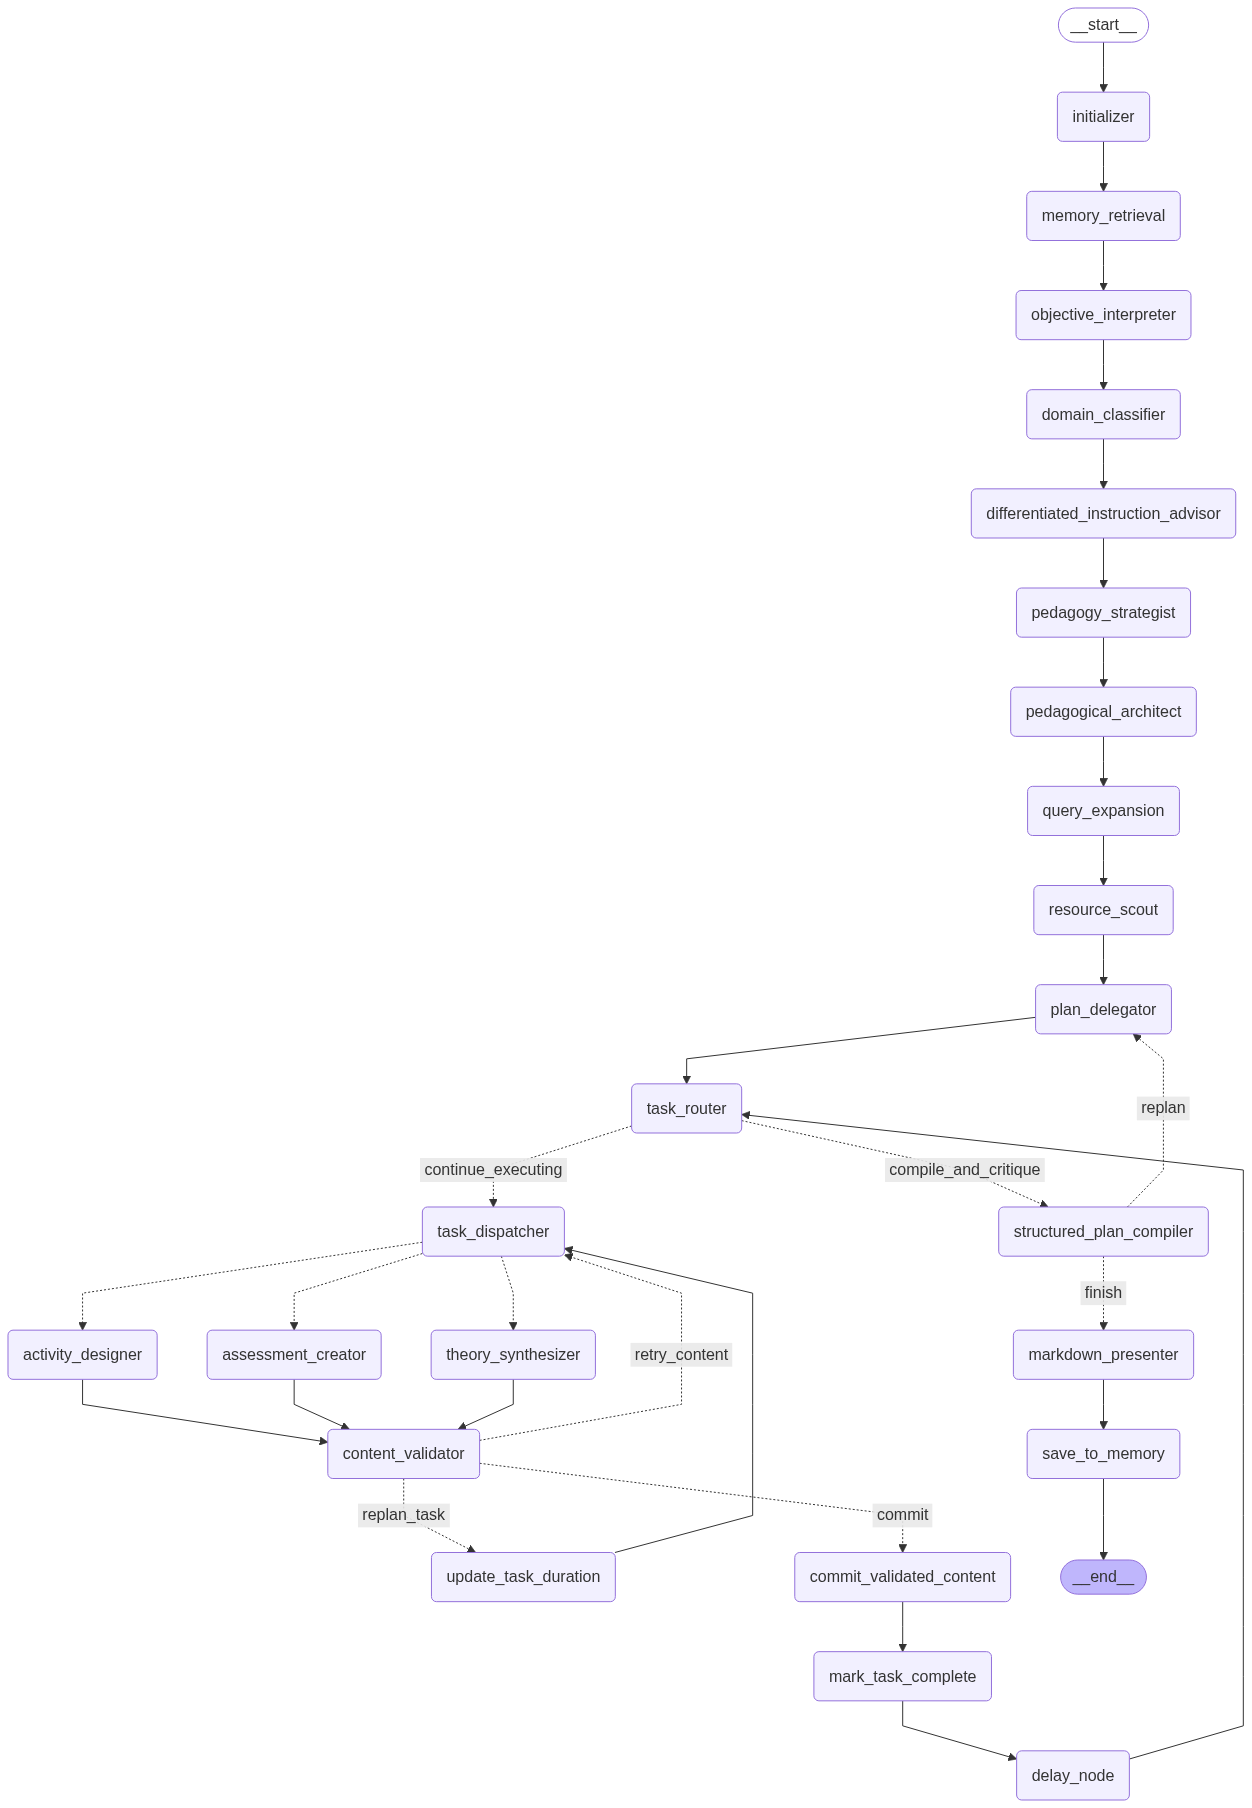

In [55]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [56]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [57]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và cần các hoạt động tương tác cao để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần dễ hiểu, cung cấp nhiều ví dụ minh họa trực quan, sử dụng phiếu bài tập có gợi ý hoặc điền khuyết, tăng cường luyện tập tại chỗ với sự hướng dẫn sát sao của giáo viên, cho phép thêm thời gian hoàn thành nhiệm vụ.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, mở rộng kiến thức liên quan (ví dụ: các tính chất đặc biệt của đường tròn, ứng dụng trong thực tế), khuyến khích các em tự tìm tòi, khám phá thêm hoặc hướng dẫn bạn bè trong nhóm.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và có phong cách học thụ động. Việc chia nhóm giúp tăng cường tương tác giữa các học sinh, khuyến khích sự chủ động tham gia và hỗ trợ lẫn nhau. Học sinh yếu hơn có thể nhận được sự giúp đỡ từ bạn bè trong nhóm, trong khi học sinh khá giỏi có cơ hội củng cố kiến thức và phát triển kỹ năng hướng dẫn. Các hoạt động nhóm đa dạng, luân phiên sẽ duy trì sự chú ý và hứng thú của học sinh trong suốt 90 phút, đồng thời giúp giáo viên dễ dàng quan sát, hỗ trợ và phân hóa kiến thức theo từng nhóm đối tượng.',
│   'key_actions': [
│   │   'Chia nhóm và giao nhiệm vụ học tập cụ thể liên quan đến đường tròn ngoại tiếp và nội tiếp (ví dụ: khám phá định nghĩa, tính chất, cách vẽ, giải bài tập cơ bản).',
│   │   'Học sinh làm việc nhóm, cùng nhau thảo luận, nghiên cứu tài liệu, thực hiện các hoạt động (vẽ hình, chứng minh, giải bài tập) dưới sự hướng dẫn và hỗ trợ của giáo viên.',
│   │   'Đại diện các nhóm trình bày sản phẩm hoặc kết quả thảo luận của nhóm mình trước lớp.',
│   │   'Giáo viên nhận xét, bổ sung, tổng hợp các kiến thức trọng tâm, giải đáp thắc mắc và chuẩn hóa bài học.',
│   │   'Giáo viên đánh giá hoạt động nhóm và kết quả học tập của học sinh, đưa ra phản hồi để cải thiện.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   "Khởi động và Khám phá ban đầu: Giáo viên sử dụng hình ảnh/video ngắn về các vật thể có hình dạng liên quan (ví dụ: bánh xe, đồng xu, logo) hoặc các hình vẽ đơn giản để đặt câu hỏi gợi mở. Tổ chức hoạt động 'Ghép đôi' hoặc 'Đố vui nhanh' về các yếu tố cơ bản của đường tròn và tam giác. Dẫn dắt học sinh đến câu hỏi 'Làm thế nào để vẽ một đường tròn đi qua 3 đỉnh của tam giác?' hoặc 'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'.",
│   'Xây dựng kiến thức cốt lõi (Học tập hợp tác): Chia lớp thành các nhóm nhỏ (4-5 học sinh). Mỗi nhóm nhận một phiếu học tập có các nhiệm vụ cụ thể: Nhiệm vụ 1: Vẽ một tam giác bất kỳ và tìm cách vẽ đường tròn đi qua 3 đỉnh của nó (đường tròn ngoại tiếp). Nhiệm vụ 2: Vẽ một tam giác bất kỳ và tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của nó (đường tròn nội tiếp). Nhiệm vụ 3: Thảo luận và ghi lại định nghĩa, tính chất, cách xác định tâm và bán kính của mỗi loại đường tròn. Giáo viên đi quanh các nhóm, quan sát, gợi ý, hỗ trợ và giải đáp thắc mắc. Khuyến khích học sinh yếu hơn đặt câu hỏi và học sinh khá giỏi hướng dẫn bạn.',
│   "Vận dụng và Luyện tập cơ bản: Giáo viên cung cấp các bài tập vận dụng từ dễ đến trung bình. Bài tập nhóm: Các nhóm tiếp tục làm việc để giải quyết 1-2 bài tập áp dụng trực tiếp (ví dụ: 'Cho tam giác ABC vuông tại A, hãy xác định tâm và bán kính đường tròn ngoại tiếp tam giác đó'). Bài tập cá nhân: Mỗi học sinh làm 1-2 bài tập tương tự vào vở để củng cố. Giáo viên theo dõi, hỗ chữa các nhóm/cá nhân gặp khó khăn. Khuyến khích học sinh khá giỏi thử sức với các bài tập có thêm một bước suy luận nhỏ.",
│   'Tổng kết, Củng cố và Mở rộng: Đại diện 1-2 nhóm trình bày kết quả/cách giải của một bài tập tiêu biểu. Giáo viên tổng hợp, chuẩn hóa kiến thức về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Sử dụng sơ đồ tư duy hoặc bảng so sánh để học sinh dễ hình dung. Giải đáp các câu hỏi của học sinh. Đối với học sinh khá giỏi, giáo viên có thể đưa ra một bài toán nhỏ có tính chất mở rộng hoặc gợi ý về các tính chất đặc biệt của đường tròn ngoại tiếp/nội tiếp trong tam giác đều, tam giác vuông.',
│   'Đánh giá và Giao nhiệm vụ về nhà: Giáo viên cho học sinh làm một bài tập trắc nghiệm nhanh hoặc điền khuyết 2-3 câu để kiểm tra mức độ hiểu bài. Thu phiếu học tập nhóm để đánh giá quá trình. Giao bài tập về nhà bao gồm các dạng bài đã học và một số bài tập nâng cao (có đánh dấu) cho học sinh khá giỏi tự luyện tập. Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp là gì',
│   'đường tròn nội tiếp là gì',
│   'công thức bán kính đường tròn ngoại tiếp tam giác',
│   'công thức bán kính đường tròn nội tiếp tam giác',
│   'tính chất đường tròn ngoại tiếp và nội tiếp',
│   'bài tập đường tròn ngoại tiếp tam giác',
│   'bài tập đường tròn nội tiếp tam giác',
│   'tâm đường tròn ngoại tiếp tam giác',
│   'tâm đường tròn nội tiếp tam giác',
│   'đường tròn ngoại tiếp tứ giác',
│   'đường tròn nội tiếp tứ giác',
│   'cách vẽ đường tròn ngoại tiếp tam giác',
│   'cách vẽ đường tròn nội tiếp tam giác',
│   'ứng dụng đường tròn ngoại tiếp nội tiếp',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp',
│   'toán 9 đường tròn ngoại tiếp nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp nội tiếp',
│   'bài tập nâng cao đường tròn ngoại tiếp nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'đường tròn bàng tiếp tam giác'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào em,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, thầy sẽ giúp em tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn" dựa trên các đoạn văn bản đã cho. Mặc dù các đoạn văn bản này chủ yếu giới thiệu về đường tròn cơ bản, nhưng thầy sẽ chắt lọc những điểm quan trọng nhất.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN**\n\nDựa trên các đoạn văn bản được cung cấp, kiến thức cốt lõi về đường tròn bao gồm các điểm sau:\n\n**1. Định nghĩa Đường tròn**\n*   **Khái niệm:** Đường tròn tâm O bán kính R ($R > 0$), kí hiệu là $(O, R)$ hoặc $(O)$, là hình gồm tất cả các điểm cách điểm O một khoảng bằng R.\n*   **Điểm thuộc đường tròn:** Nếu A là một điểm của đường tròn (O), ta viết $A \\in (O)$. Khi đó, đường tròn (O) đi qua điểm A, hay điểm A nằm trên đường tròn (O).\n\n**2. Vị trí của một điểm đối với Đường tròn**\nCho đường tròn $(O; R)$ và điểm M:\n*   Điểm M nằm **trên** đường tròn $(O; R)$ nếu $OM = R$.\n*   Điểm M nằm **trong** đường tròn $(O; R)$ nếu $OM < R$.\n*   Điểm M nằm **ngoài** đường tròn $(O; R)$ nếu $OM > R$.\n\n**3. Hình tròn**\n*   **Định nghĩa:** Hình tròn tâm O bán kính R là hình gồm các điểm nằm trên và nằm trong đường tròn $(O; R)$.\n\n**4. Tính đối xứng của Đường tròn**\n*   **Tâm đối xứng:** Đường tròn có tâm O là tâm đối xứng.\n*   **Trục đối xứng:** Đường tròn có mọi đường thẳng đi qua tâm O là trục đối xứng.\n\n**5. Các mối quan hệ giữa hai Đường tròn (được đề cập trong bài tập)**\nMặc dù các định nghĩa chi tiết không được cung cấp trong phần lý thuyết, nhưng các bài tập đã đề cập đến các mối quan hệ sau giữa hai đường tròn:\n*   **Cắt nhau:** Hai đường tròn có thể cắt nhau tại hai điểm.\n*   **Không giao nhau:** Hai đường tròn có thể không có điểm chung.\n*   **Tiếp xúc:** Hai đường tròn có thể tiếp xúc với nhau (tiếp xúc trong hoặc tiếp xúc ngoài) tại một điểm duy nhất.\n\n---\n\nHy vọng bản tóm tắt này giúp em nắm vững các khái niệm cơ bản về đường tròn từ tài liệu đã cho.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.7 - Tư duy Linh hoạt) đang triển khai Bản thiết kế...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá ban đầu',
│   │   'task_description': "Giáo viên sử dụng hình ảnh/video ngắn về các vật thể có hình dạng liên quan (ví dụ: bánh xe, đồng xu, logo) hoặc các hình vẽ đơn giản để đặt câu hỏi gợi mở. Tổ chức hoạt động 'Ghép đôi' hoặc 'Đố vui nhanh' về các yếu tố cơ bản của đường tròn và tam giác. Dẫn dắt học sinh đến câu hỏi 'Làm thế nào để vẽ một đường tròn đi qua 3 đỉnh của tam giác?' hoặc 'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'.",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức cốt lõi (Học tập hợp tác)',
│   │   'task_description': 'Chia lớp thành các nhóm nhỏ (4-5 học sinh). Mỗi nhóm nhận một phiếu học tập có các nhiệm vụ cụ thể: Nhiệm vụ 1: Vẽ một tam giác bất kỳ và tìm cách vẽ đường tròn đi qua 3 đỉnh của nó (đường tròn ngoại tiếp). Nhiệm vụ 2: Vẽ một tam giác bất kỳ và tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của nó (đường tròn nội tiếp). Nhiệm vụ 3: Thảo luận và ghi lại định nghĩa, tính chất, cách xác định tâm và bán kính của mỗi loại đường tròn. Giáo viên đi quanh các nhóm, quan sát, gợi ý, hỗ trợ và giải đáp thắc mắc.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng và Luyện tập cơ bản',
│   │   'task_description': 'Giáo viên cung cấp các bài tập vận dụng từ dễ đến trung bình. Học sinh làm bài tập nhóm (1-2 bài) và bài tập cá nhân (1-2 bài) để áp dụng trực tiếp kiến thức về đường tròn ngoại tiếp và nội tiếp. Giáo viên theo dõi, hỗ trợ các nhóm/cá nhân gặp khó khăn. Khuyến khích học sinh khá giỏi thử sức với các bài tập có thêm một bước suy luận nhỏ.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Tổng kết, Củng cố và Mở rộng',
│   │   'task_description': 'Đại diện 1-2 nhóm trình bày kết quả/cách giải của một bài tập tiêu biểu. Giáo viên tổng hợp, chuẩn hóa kiến thức về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Sử dụng sơ đồ tư duy hoặc bảng so sánh để học sinh dễ hình dung. Giải đáp các câu hỏi của học sinh. Hoạt động này có thể co giãn. Ưu tiên củng cố các kiến thức cơ bản. Các nội dung mở rộng hoặc bài tập nâng cao là phần bổ sung nếu còn thời gian.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   │   'task_description': 'Giáo viên cho học sinh làm một bài tập trắc nghiệm nhanh hoặc điền khuyết 2-3 câu để kiểm tra mức độ hiểu bài. Thu phiếu học tập nhóm để đánh giá quá trình. Giao bài tập về nhà bao gồm các dạng bài đã học và một số bài tập nâng cao (có đánh dấu) cho học sinh khá giỏi tự luyện tập. Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Khởi động và Khám phá ban đầu: Đường tròn ngoại tiếp và nội tiếp',
│   'activity_type': 'Hoạt động khởi động, gợi mở và thảo luận nhóm nhỏ',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Chiếu hình ảnh/video các vật thể có hình dạng đường tròn và tam giác (ví dụ: bánh xe, logo, biển báo giao thông).',
│   │   "Đặt câu hỏi gợi mở: 'Các em thấy hình tròn và hình tam giác xuất hiện ở đâu trong cuộc sống?'",
│   │   "Tổ chức hoạt động 'Ghép đôi' hoặc 'Đố vui nhanh' về các khái niệm cơ bản của đường tròn (tâm, bán kính, dây cung, đường kính) và tam giác (đỉnh, cạnh, góc).",
│   │   "Dẫn dắt học sinh đến câu hỏi trọng tâm: 'Làm thế nào để vẽ một đường tròn đi qua 3 đỉnh của tam giác?' và 'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'",
│   │   'Lắng nghe và ghi nhận các ý tưởng ban đầu của học sinh.'
│   ],
│   'core_component': "Học sinh quan sát hình ảnh/video các vật thể có hình dạng đường tròn và tam giác (ví dụ: bánh xe, logo, biển báo giao thông). Sau đó, tham gia hoạt động 'Ghép đôi' hoặc 'Đố vui nhanh' để ôn tập các khái niệm cơ bản về đường tròn (tâm, bán kính, dây cung, đường kính) và tam giác (đỉnh, cạnh, góc). Tiếp theo, giáo viên đặt hai câu hỏi lớn: 'Làm thế nào để vẽ một đường tròn đi qua 3 đỉnh của tam giác?' và 'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'. Học sinh thảo luận nhóm nhỏ (2-3 phút) để đưa ra các ý tưởng ban đầu hoặc các câu hỏi liên quan.",
│   'extension_component': "Nếu còn thời gian, học sinh suy nghĩ: 'Liệu có phải tam giác nào cũng có đường tròn đi qua 3 đỉnh và đường tròn tiếp xúc với 3 cạnh không?' hoặc 'Có bao nhiêu đường tròn như vậy cho một tam giác cố định?'",
│   'solution_guide': "Các câu hỏi gợi mở: 'Điểm nào cách đều 3 đỉnh của tam giác?', 'Điểm nào cách đều 3 cạnh của tam giác?', 'Các đường đặc biệt nào trong tam giác có tính chất này?'",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể cung cấp phiếu bài tập 'Ghép đôi' có hình ảnh minh họa rõ ràng hoặc các câu hỏi trắc nghiệm đơn giản về khái niệm cơ bản. Gợi ý trực tiếp hơn về mối liên hệ giữa các điểm đặc biệt của tam giác và tâm đường tròn.",
│   │   'for_advanced_students': 'Khuyến khích học sinh suy nghĩ về các trường hợp đặc biệt của tam giác (tam giác vuông, tam giác đều) và dự đoán vị trí của tâm đường tròn ngoại tiếp/nội tiếp trong các trường hợp đó.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh quan sát hình ảnh/video các vật thể có hình dạng đường tròn và tam giác (ví dụ: bánh xe, logo, biển báo giao thông). Sau đó, tham gia hoạt động 'Ghép đôi' hoặc 'Đố vui nhanh' để ôn tập các khái niệm cơ bản về đường tròn (tâm, bán kính, dây cung, đường kính) và tam giác (đỉnh, cạnh, góc). Tiếp theo, giáo viên đặt hai câu hỏi lớn: 'Làm thế nào để vẽ một đường tròn đi qua 3 đỉnh của tam giác?' và 'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'. Học sinh thảo luận nhóm nhỏ (2-3 phút) để đưa ra các ý tưởng ban đầu hoặc các câu hỏi liên quan.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh suy nghĩ: 'Liệu có phải tam giác nào cũng có đường tròn đi qua 3 đỉnh và đường tròn tiếp xúc với 3 cạnh không?' hoặc 'Có bao nhiêu đường tròn như vậy cho một tam giác cố định?'"
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xây dựng kiến thức cốt lõi (Học tập hợp tác)' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Xây dựng kiến thức cốt lõi (Học tập hợp tác)',
│   'activity_type': 'Học tập hợp tác',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Chia lớp thành các nhóm 4-5 học sinh và phát phiếu học tập cùng dụng cụ (thước, compa).',
│   │   'Đi quanh các nhóm, quan sát tiến độ và lắng nghe thảo luận của học sinh.',
│   │   "Gợi ý, đặt câu hỏi dẫn dắt khi học sinh gặp khó khăn (ví dụ: 'Để vẽ đường tròn đi qua 3 đỉnh, tâm của nó phải cách đều 3 đỉnh. Vậy điểm nào cách đều 3 đỉnh của tam giác?').",
│   │   'Hỗ trợ về kỹ năng sử dụng dụng cụ học tập nếu cần.',
│   │   'Giải đáp thắc mắc và chỉnh sửa sai lầm kịp thời cho các nhóm.',
│   │   'Khuyến khích các nhóm trình bày kết quả và chia sẻ phương pháp tìm ra tâm và bán kính của đường tròn.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người) với phiếu học tập. Nhiệm vụ 1 (10 phút): Vẽ một tam giác bất kỳ và sử dụng compa, thước để tìm cách vẽ đường tròn đi qua 3 đỉnh của nó (đường tròn ngoại tiếp). Ghi lại các bước thực hiện và nhận xét về tâm của đường tròn. Nhiệm vụ 2 (10 phút): Vẽ một tam giác bất kỳ khác và tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của nó (đường tròn nội tiếp). Ghi lại các bước thực hiện và nhận xét về tâm của đường tròn. Nhiệm vụ 3 (5 phút): Thảo luận trong nhóm để tổng hợp và ghi lại định nghĩa, tính chất cơ bản, và cách xác định tâm, bán kính của đường tròn ngoại tiếp và đường tròn nội tiếp tam giác.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: Thử thách 1: Với tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu? Với tam giác đều, tâm đường tròn ngoại tiếp và nội tiếp có trùng nhau không? Thử thách 2: Tìm hiểu ứng dụng của đường tròn ngoại tiếp/nội tiếp trong thực tế hoặc trong các bài toán hình học khác (ví dụ: tính diện tích tam giác thông qua bán kính đường tròn nội tiếp/ngoại tiếp).',
│   'solution_guide': 'Đường tròn ngoại tiếp: Tâm là giao điểm của 3 đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến 3 đỉnh. Đường tròn nội tiếp: Tâm là giao điểm của 3 đường phân giác của tam giác. Bán kính là khoảng cách từ tâm đến 3 cạnh (vuông góc với cạnh). Gợi mở: Tại sao tâm đường tròn ngoại tiếp lại là giao điểm của 3 đường trung trực? Tại sao tâm đường tròn nội tiếp lại là giao điểm của 3 đường phân giác? Kiểm tra: Yêu cầu học sinh dùng compa kiểm tra lại xem đường tròn đã vẽ có thực sự đi qua 3 đỉnh/tiếp xúc 3 cạnh chưa.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tam giác đã được vẽ sẵn trên phiếu, hoặc phiếu có các bước gợi ý/điền khuyết để tìm tâm đường tròn. Giáo viên dành thời gian hướng dẫn trực tiếp, kiểm tra từng bước thực hiện của nhóm và cung cấp thêm ví dụ minh họa trực quan.',
│   │   'for_advanced_students': 'Khuyến khích các em tự chứng minh các tính chất về tâm đường tròn (ví dụ: tâm đường tròn ngoại tiếp là giao điểm 3 đường trung trực). Giao thêm các bài tập mở rộng như tìm tâm đường tròn ngoại tiếp/nội tiếp của các hình đặc biệt khác (ví dụ: tứ giác nội tiếp/ngoại tiếp) hoặc các bài toán ứng dụng thực tế.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (4-5 người) với phiếu học tập. Nhiệm vụ 1 (10 phút): Vẽ một tam giác bất kỳ và sử dụng compa, thước để tìm cách vẽ đường tròn đi qua 3 đỉnh của nó (đường tròn ngoại tiếp). Ghi lại các bước thực hiện và nhận xét về tâm của đường tròn. Nhiệm vụ 2 (10 phút): Vẽ một tam giác bất kỳ khác và tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của nó (đường tròn nội tiếp). Ghi lại các bước thực hiện và nhận xét về tâm của đường tròn. Nhiệm vụ 3 (5 phút): Thảo luận trong nhóm để tổng hợp và ghi lại định nghĩa, tính chất cơ bản, và cách xác định tâm, bán kính của đường tròn ngoại tiếp và đường tròn nội tiếp tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: Thử thách 1: Với tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu? Với tam giác đều, tâm đường tròn ngoại tiếp và nội tiếp có trùng nhau không? Thử thách 2: Tìm h

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng và Luyện tập cơ bản' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Vận dụng và Luyện tập cơ bản',
│   'activity_type': 'Thực hành nhóm và cá nhân',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập cho từng nhóm/cá nhân.',
│   │   'Đi lại quan sát, lắng nghe các nhóm thảo luận và làm bài.',
│   │   'Kịp thời hỗ trợ, gợi ý cho các nhóm/cá nhân gặp khó khăn (ví dụ: nhắc lại công thức, vẽ hình minh họa).',
│   │   'Khuyến khích học sinh khá giỏi thử sức với các bài tập mở rộng.',
│   │   'Chọn một vài bài tập tiêu biểu để chữa nhanh hoặc yêu cầu học sinh lên bảng trình bày (nếu còn thời gian).'
│   ],
│   'core_component': 'Học sinh làm các bài tập vận dụng cơ bản về đường tròn ngoại tiếp và nội tiếp.\n*   **Bài tập nhóm (10 phút):**\n    *   **Bài 1:** Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm.\n        a) Tính độ dài cạnh BC.\n        b) Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n        c) Tính bán kính đường tròn nội tiếp tam giác ABC.\n*   **Bài tập cá nhân (10 phút):**\n    *   **Bài 2:** Cho hình vuông ABCD có cạnh 10cm.\n        a) Tính bán kính đường tròn ngoại tiếp hình vuông ABCD.\n        b) Tính bán kính đường tròn nội tiếp hình vuông ABCD.\n    *   **Bài 3:** Cho tam giác đều ABC có cạnh bằng 6cm. Tính bán kính đường tròn ngoại tiếp và nội tiếp tam giác ABC.',
│   'extension_component': 'Dành cho học sinh hoàn thành sớm hoặc muốn thử thách:\n*   **Bài 4:** Cho tam giác ABC nhọn, đường cao AH. Gọi M, N lần lượt là hình chiếu của H trên AB, AC. Chứng minh bốn điểm A, M, H, N cùng thuộc một đường tròn. Xác định tâm và bán kính của đường tròn đó.\n*   **Bài 5:** Cho đường tròn (O; R) và dây AB cố định không đi qua tâm. Điểm C di chuyển trên cung lớn AB. Gọi I là tâm đường tròn nội tiếp tam giác ABC. Chứng minh rằng điểm I luôn nằm trên một đường tròn cố định.',
│   'solution_guide': '**Gợi ý giải:**\n*   **Bài 1:**\n    *   a) Dùng định lý Pytago.\n    *   b) Tam giác vuông, tâm đường tròn ngoại tiếp là trung điểm cạnh huyền.\n    *   c) Sử dụng công thức r = (a+b-c)/2 hoặc r = S/p.\n*   **Bài 2:**\n    *   a) Đường tròn ngoại tiếp hình vuông đi qua 4 đỉnh, đường kính là đường chéo hình vuông.\n    *   b) Đường tròn nội tiếp hình vuông tiếp xúc với 4 cạnh, đường kính bằng cạnh hình vuông.\n*   **Bài 3:**\n    *   Tam giác đều: R = a/√3, r = a/(2√3).\n*   **Bài 4:**\n    *   Chứng minh các góc AMH và ANH là góc vuông. Tứ giác AMHN có tổng hai góc đối bằng 180 độ hoặc hai đỉnh M, N cùng nhìn AH dưới một góc vuông. Tâm là trung điểm AH, bán kính là AH/2.\n*   **Bài 5:**\n    *   Sử dụng tính chất góc tạo bởi tia phân giác và cung bị chắn. Chứng minh góc AIC không đổi. Điểm I nhìn đoạn AC dưới một góc không đổi.',
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với Bài 1, giáo viên có thể gợi ý công thức tính bán kính đường tròn ngoại tiếp tam giác vuông (R = cạnh huyền / 2) và công thức tính bán kính đường tròn nội tiếp (r = (a+b-c)/2 hoặc r = S/p). Cung cấp phiếu bài tập có chỗ trống để điền kết quả hoặc gợi ý từng bước giải. Chỉ yêu cầu hoàn thành Bài 1 và Bài 2a.',
│   │   'for_advanced_students': 'Khuyến khích học sinh làm thêm Bài 4 và Bài 5. Yêu cầu các em trình bày lời giải chi tiết, rõ ràng, có thể yêu cầu giải thích các định lý, tính chất đã sử dụng. Nếu có thời gian, có thể yêu cầu các em tự đặt thêm một bài toán tương tự.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm các bài tập vận dụng cơ bản về đường tròn ngoại tiếp và nội tiếp.\n*   **Bài tập nhóm (10 phút):**\n    *   **Bài 1:** Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm.\n        a) Tính độ dài cạnh BC.\n        b) Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n        c) Tính bán kính đường tròn nội tiếp tam giác ABC.\n*   **Bài tập cá nhân (10 phút):**\n    *   **Bài 2:** Cho hình vuông ABCD có cạnh 10cm.\n        a) Tính bán kính đường tròn ngoại tiếp hình vuông ABCD.\n        b) Tính bán kính đường tròn nội tiếp hình vuông ABCD.\n    *   **Bài 3:** Cho tam giác đều ABC có cạnh bằng 6cm. Tính b

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời gian dự kiến 25 phút là hơi gấp gáp để học sinh có thể hoàn thành 
đầy đủ các bài tập cốt lõi và giáo viên có đủ thời gian để quan sát, hỗ trợ, cũng như chữa bài và tổng kết hiệu 
quả. Đặc biệt, việc chữa bài và yêu cầu học sinh lên bảng trình bày trong 5 phút còn lại là rất khó khả thi. Hoạt 
động này cần thêm thời gian để đảm bảo chất lượng luyện tập và củng cố kiến thức. | SUGGESTED_DURATION: 30

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 30 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 2,
│   'from': 25,
│   'to': 30
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Vận dụng và Luyện tập cơ bản',
│   'activity_type': 'Thực hành nhóm và cá nhân',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập cho học sinh (có thể bao gồm hình vẽ minh họa cho bài tập 1).',
│   │   'Quan sát các nhóm/cá nhân làm bài, đi lại trong lớp để nắm bắt tình hình.',
│   │   'Gợi ý, hướng dẫn trực tiếp cho các học sinh hoặc nhóm gặp khó khăn (ví dụ: nhắc lại công thức, gợi ý về tâm đường tròn).',
│   │   'Khuyến khích học sinh khá giỏi thử sức với bài tập mở rộng nếu hoàn thành sớm phần cốt lõi.',
│   │   'Kiểm tra nhanh kết quả của một số nhóm/cá nhân và đưa ra nhận xét chung.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (2-3 người) để giải quyết Bài tập 1, sau đó làm việc cá nhân để hoàn thành Bài tập 2. Các bài tập tập trung vào việc vận dụng trực tiếp kiến thức về đường tròn ngoại tiếp và nội tiếp.\n\nBài tập 1 (Nhóm): Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n\nBài tập 2 (Cá nhân): Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp tam giác ABC theo a.',
│   'extension_component': 'Học sinh làm nhanh hoặc còn thời gian sẽ thử sức với bài tập mở rộng, yêu cầu thêm một bước suy luận nhỏ:\n\nBài tập mở rộng: Cho hình vuông ABCD có cạnh bằng 4cm.\na) Tính bán kính đường tròn ngoại tiếp hình vuông ABCD.\nb) Tính bán kính đường tròn nội tiếp hình vuông ABCD.',
│   'solution_guide': 'Gợi ý giải:\n\nBài tập 1 (Core): Tam giác ABC vuông tại A, tâm đường tròn ngoại tiếp là trung điểm cạnh huyền BC. Bán kính R = BC/2. Sử dụng định lý Pytago để tính BC.\n\nBài tập 2 (Core): Tam giác đều ABC cạnh a. Tâm đường tròn nội tiếp trùng với trọng tâm. Bán kính r = a*căn(3)/6 (hoặc gợi ý sử dụng công thức diện tích S = p*r).\n\nBài tập mở rộng (Extension):\na) Đường tròn ngoại tiếp hình vuông có đường kính là đường chéo của hình vuông. Đường chéo hình vuông cạnh a là a*căn(2).\nb) Đường tròn nội tiếp hình vuông có đường kính bằng cạnh hình vuông.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu bài tập có sẵn hình vẽ hoặc các gợi ý công thức, các bước giải cơ bản. Giáo viên có thể trực tiếp hướng dẫn từng bước giải hoặc đặt câu hỏi gợi mở để học sinh tự tìm ra. Cho phép học sinh thảo luận nhiều hơn với bạn bè trong nhóm.',
│   │   'for_advanced_students': 'Khuyến khích các em giải thích cách làm và các bước suy luận cho bài tập mở rộng. Nếu hoàn thành sớm, có thể yêu cầu các em tự đặt một bài toán tương tự hoặc tìm hiểu ứng dụng của đường tròn ngoại tiếp/nội tiếp trong thực tế (ví dụ: trong kiến trúc, thiết kế).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (2-3 người) để giải quyết Bài tập 1, sau đó làm việc cá nhân để hoàn thành Bài tập 2. Các bài tập tập trung vào việc vận dụng trực tiếp kiến thức về đường tròn ngoại tiếp và nội tiếp.\n\nBài tập 1 (Nhóm): Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n\nBài tập 2 (Cá nhân): Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp tam giác ABC theo a.\n\n**Phần Mở rộng (nếu còn thời gian):**\nHọc sinh làm nhanh hoặc còn thời gian sẽ thử sức với bài tập mở rộng, yêu cầu thêm một bước suy luận nhỏ:\n\nBài tập mở rộng: Cho hình vuông ABCD có cạnh bằng 4cm.\na) Tính bán kính đường tròn ngoại tiếp hình vuông ABCD.\nb) Tính bán kính đường tròn nội tiếp hình vuông ABCD.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết, Củng cố và Mở rộng' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Tổng kết, Củng cố và Mở rộng Kiến thức Đường tròn Ngoại tiếp và Nội tiếp',
│   'activity_type': 'Tổng kết và Củng cố kiến thức',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Mời 1-2 nhóm đại diện trình bày lời giải/kết quả của bài tập đã giao về đường tròn ngoại tiếp/nội tiếp.',
│   │   'Lắng nghe, nhận xét và chuẩn hóa kiến thức trình bày của học sinh.',
│   │   'Sử dụng sơ đồ tư duy hoặc bảng so sánh (đã chuẩn bị sẵn hoặc cùng học sinh xây dựng nhanh) để tổng hợp các định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp.',
│   │   'Giải đáp các thắc mắc, câu hỏi của học sinh về các kiến thức cơ bản.',
│   │   'Giao bài tập mở rộng hoặc câu hỏi nâng cao cho học sinh hoàn thành nếu còn thời gian.'
│   ],
│   'core_component': 'Trong 10-12 phút đầu, giáo viên mời đại diện 1-2 nhóm (đã được chuẩn bị trước hoặc chọn ngẫu nhiên) lên bảng trình bày cách giải một bài tập tiêu biểu về xác định tâm và bán kính của đường tròn ngoại tiếp hoặc nội tiếp của một tam giác cụ thể (ví dụ: tam giác vuông, tam giác đều). Sau đó, giáo viên tổng hợp và chuẩn hóa kiến thức bằng cách sử dụng sơ đồ tư duy hoặc bảng so sánh lớn trên bảng/máy chiếu, tập trung vào: 1. Định nghĩa đường tròn ngoại tiếp/nội tiếp. 2. Tâm của đường tròn ngoại tiếp/nội tiếp (giao điểm của đường gì?). 3. Bán kính của đường tròn ngoại tiếp/nội tiếp. 4. Cách xác định tâm và bán kính trong các trường hợp tam giác đặc biệt (vuông, cân, đều). Giáo viên dành thời gian giải đáp các câu hỏi cơ bản của học sinh để đảm bảo tất cả nắm vững kiến thức cốt lõi.',
│   'extension_component': "Nếu còn 3-5 phút cuối, giáo viên có thể đưa ra một trong các hoạt động sau: 1. Bài tập nâng cao: 'Cho tam giác ABC có AB=3cm, AC=4cm, BC=5cm. Tính bán kính đường tròn ngoại tiếp và nội tiếp của tam giác ABC.' 2. Câu hỏi mở rộng: 'Ngoài các tính chất đã học, em có biết thêm tính chất đặc biệt nào của đường tròn ngoại tiếp/nội tiếp không?' hoặc 'Trong thực tế, đường tròn ngoại tiếp/nội tiếp được ứng dụng ở đâu?' 3. Thử thách tư duy: 'Có phải mọi tứ giác đều có đường tròn ngoại tiếp và nội tiếp không? Giải thích.'",
│   'solution_guide': 'Các điểm cần nhấn mạnh khi tổng kết: Đường tròn ngoại tiếp: Tâm là giao điểm 3 đường trung trực; bán kính R = a/(2sinA) = abc/(4S). Với tam giác vuông, tâm là trung điểm cạnh huyền, R = cạnh huyền/2. Đường tròn nội tiếp: Tâm là giao điểm 3 đường phân giác; bán kính r = S/p (S là diện tích, p là nửa chu vi). Bài tập mở rộng (tam giác 3,4,5): Đây là tam giác vuông tại A. Bán kính đường tròn ngoại tiếp R = BC/2 = 5/2 = 2.5 cm. Diện tích S = (1/2) * AB * AC = (1/2) * 3 * 4 = 6 cm². Nửa chu vi p = (3+4+5)/2 = 6 cm. Bán kính đường tròn nội tiếp r = S/p = 6/6 = 1 cm.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên tập trung vào việc củng cố các định nghĩa và cách xác định tâm/bán kính cơ bản thông qua sơ đồ tư duy/bảng so sánh. Có thể cung cấp phiếu học tập điền khuyết cho sơ đồ hoặc bảng so sánh để các em dễ theo dõi và ghi nhớ. Khuyến khích các em đặt câu hỏi về những phần chưa rõ và dành thời gian giải thích thêm.',
│   │   'for_advanced_students': 'Khuyến khích các em tham gia giải bài tập mở rộng (nếu có) hoặc suy nghĩ về các câu hỏi nâng cao. Các em có thể được yêu cầu giải thích sâu hơn về mối liên hệ giữa các tính chất hoặc tìm kiếm các ứng dụng thực tế. Nếu có học sinh gặp khó khăn, các em có thể hỗ trợ giải thích cho bạn dưới sự hướng dẫn của giáo viên.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nTrong 10-12 phút đầu, giáo viên mời đại diện 1-2 nhóm (đã được chuẩn bị trước hoặc chọn ngẫu nhiên) lên bảng trình bày cách giải một bài tập tiêu biểu về xác định tâm và bán kính của đường tròn ngoại tiếp hoặc nội tiếp của một tam giác cụ thể (ví dụ: tam giác vuông, tam giác đều). Sau đó, giáo viên tổng hợp và chuẩn hóa kiến thức bằng cách sử dụng sơ đồ tư duy hoặc bảng so sánh lớn trên bảng/máy chiếu, tập trung vào: 1. Định nghĩa đường tròn ngoại tiếp/nội tiếp

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (15 phút) quá lớn so với thời 
gian còn lại (20 phút) cho TẤT CẢ các hoạt động sau. Hoạt động này chiếm 75% tổng thời gian còn lại, có thể không 
đủ thời gian cho các hoạt động kết thúc buổi học khác (ví dụ: giao bài tập về nhà, dặn dò, chuẩn bị cho buổi học 
tiếp theo). Cần thiết kế lại hoạt động này trong khoảng 10-12 phút để đảm bảo tiến độ chung của buổi học. | 
SUGGESTED_DURATION: 12

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 12 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 3,
│   'from': 15,
│   'to': 12
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Tổng kết, Củng cố và Mở rộng',
│   'activity_type': 'Tổng kết và Củng cố kiến thức',
│   'duration_minutes': 12,
│   'teacher_actions': [
│   │   'Mời 1-2 nhóm đại diện trình bày bài tập đã chuẩn bị.',
│   │   'Lắng nghe, nhận xét và chuẩn hóa phần trình bày của học sinh.',
│   │   'Sử dụng sơ đồ tư duy hoặc bảng so sánh để tổng hợp và hệ thống hóa kiến thức về đường tròn ngoại tiếp và nội tiếp (định nghĩa, tính chất, cách xác định tâm, bán kính).',
│   │   'Giải đáp các thắc mắc của học sinh về kiến thức cơ bản.',
│   │   'Quan sát mức độ hiểu bài của học sinh để điều chỉnh tốc độ và nội dung.'
│   ],
│   'core_component': 'Đại diện 1-2 nhóm trình bày kết quả/cách giải của một bài tập tiêu biểu về đường tròn ngoại tiếp/nội tiếp. Giáo viên tổng hợp, chuẩn hóa kiến thức trọng tâm về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp bằng cách sử dụng sơ đồ tư duy hoặc bảng so sánh trên bảng/máy chiếu. Giáo viên giải đáp các câu hỏi cơ bản của học sinh để đảm bảo tất cả nắm vững kiến thức cốt lõi.',
│   'extension_component': "Nếu còn thời gian (khoảng 2-3 phút), giáo viên có thể đưa ra một câu hỏi mở rộng hoặc bài tập nâng cao nhanh như: 'Hãy nêu một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp trong đời sống/kỹ thuật.' hoặc 'Chứng minh rằng tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền.'",
│   'solution_guide': "Sơ đồ tư duy/bảng so sánh cần làm nổi bật sự khác biệt và điểm chung giữa hai loại đường tròn (ví dụ: tâm là giao điểm của đường gì, bán kính là khoảng cách từ tâm đến đâu). Gợi ý các câu hỏi để học sinh tự trả lời khi tổng kết: 'Đường tròn ngoại tiếp là gì?', 'Tâm đường tròn nội tiếp được xác định như thế nào?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình tổng hợp, giáo viên có thể dừng lại để hỏi các câu hỏi gợi mở, yêu cầu học sinh nhắc lại các định nghĩa cơ bản, hoặc cung cấp phiếu tóm tắt kiến thức điền khuyết để các em dễ theo dõi và ghi nhớ.',
│   │   'for_advanced_students': 'Khuyến khích các em đặt câu hỏi sâu hơn về mối liên hệ giữa các tính chất hoặc ứng dụng thực tế. Nếu có bài tập mở rộng, ưu tiên các em làm trước hoặc yêu cầu các em tự tổng hợp kiến thức theo cách riêng (sơ đồ tư duy cá nhân) và chia sẻ.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nĐại diện 1-2 nhóm trình bày kết quả/cách giải của một bài tập tiêu biểu về đường tròn ngoại tiếp/nội tiếp. Giáo viên tổng hợp, chuẩn hóa kiến thức trọng tâm về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp bằng cách sử dụng sơ đồ tư duy hoặc bảng so sánh trên bảng/máy chiếu. Giáo viên giải đáp các câu hỏi cơ bản của học sinh để đảm bảo tất cả nắm vững kiến thức cốt lõi.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian (khoảng 2-3 phút), giáo viên có thể đưa ra một câu hỏi mở rộng hoặc bài tập nâng cao nhanh như: 'Hãy nêu một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp trong đời sống/kỹ thuật.' hoặc 'Chứng minh rằng tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền.'"
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: Nội dung hoạt động "Tổng kết, Củng cố và Mở rộng" được thiết kế khá tốt về mặt chuyên môn và 
sư phạm, với các thành phần cốt lõi, mở rộng và phân hóa rõ ràng. Tuy nhiên, có lỗi nghiêm trọng về phân bổ ngân 
sách thời gian. [STRUCTURAL_FEEDBACK] Thời gian đề xuất (12 phút) quá lớn so với tổng thời gian còn lại của buổi 
học (20 phút). Hoạt động này chiếm 60% tổng thời gian còn lại, có thể ảnh hưởng đến việc hoàn thành các hoạt động 
tiếp theo hoặc phần kết thúc buổi học. Để đảm bảo tiến độ và vẫn giữ được chất lượng cốt lõi, hoạt động này cần 
được thiết kế lại trong khoảng 10 phút. | SUGGESTED_DURATION: 10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 10 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 3,
│   'from': 12,
│   'to': 10
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Tổng kết, Củng cố và Mở rộng',
│   'activity_type': 'Tổng kết và Củng cố kiến thức',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Mời 1-2 nhóm trình bày bài tập tiêu biểu (khoảng 3-4 phút).',
│   │   'Tổng hợp và chuẩn hóa kiến thức về đường tròn ngoại tiếp và nội tiếp (định nghĩa, tính chất, cách xác định tâm và bán kính) bằng sơ đồ tư duy/bảng so sánh (khoảng 4-5 phút).',
│   │   'Giải đáp các câu hỏi của học sinh (khoảng 1-2 phút).',
│   │   'Quan sát và hỗ trợ các nhóm trong quá trình trình bày.'
│   ],
│   'core_component': 'Giáo viên mời 1-2 nhóm đại diện trình bày nhanh kết quả/cách giải của một bài tập tiêu biểu đã giao về đường tròn ngoại tiếp hoặc nội tiếp (ví dụ: xác định tâm, bán kính của đường tròn ngoại tiếp/nội tiếp một tam giác cụ thể). Sau đó, giáo viên tổng hợp, chuẩn hóa kiến thức về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Giáo viên có thể sử dụng sơ đồ tư duy hoặc bảng so sánh trên bảng/máy chiếu để học sinh dễ hình dung và hệ thống hóa kiến thức. Giáo viên giải đáp các câu hỏi cơ bản của học sinh để củng cố sự hiểu biết.',
│   'extension_component': "Nếu còn thời gian (khoảng 1-2 phút cuối), giáo viên có thể đưa ra một câu hỏi mở rộng hoặc thử thách nhanh: 'Có phải mọi tứ giác đều có đường tròn ngoại tiếp không? Vì sao?' hoặc 'Hãy nêu một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp mà em biết.'",
│   'solution_guide': 'Hướng dẫn giải/Gợi mở: Đối với phần tổng hợp kiến thức, giáo viên cần nhấn mạnh: Đường tròn ngoại tiếp (tâm là giao điểm 3 đường trung trực, bán kính là khoảng cách từ tâm đến đỉnh); Đường tròn nội tiếp (tâm là giao điểm 3 đường phân giác, bán kính là khoảng cách từ tâm đến cạnh). Đối với câu hỏi mở rộng: Không phải mọi tứ giác đều có đường tròn ngoại tiếp (chỉ tứ giác nội tiếp). Ứng dụng thực tế: thiết kế kiến trúc, cơ khí, nghệ thuật, v.v.',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình tổng hợp kiến thức, giáo viên có thể cung cấp phiếu tóm tắt kiến thức dạng điền khuyết hoặc sơ đồ tư duy có sẵn một phần để học sinh hoàn thiện. Tập trung vào việc nhận diện đúng định nghĩa và các tính chất cơ bản nhất của tâm và bán kính.',
│   │   'for_advanced_students': 'Khuyến khích các em đặt câu hỏi sâu hơn về mối liên hệ giữa đường tròn ngoại tiếp/nội tiếp với các tính chất đặc biệt của tam giác/tứ giác (ví dụ: tam giác đều, tam giác vuông). Hoặc yêu cầu các em suy nghĩ về cách chứng minh một tính chất nào đó đã được tổng hợp.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nGiáo viên mời 1-2 nhóm đại diện trình bày nhanh kết quả/cách giải của một bài tập tiêu biểu đã giao về đường tròn ngoại tiếp hoặc nội tiếp (ví dụ: xác định tâm, bán kính của đường tròn ngoại tiếp/nội tiếp một tam giác cụ thể). Sau đó, giáo viên tổng hợp, chuẩn hóa kiến thức về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Giáo viên có thể sử dụng sơ đồ tư duy hoặc bảng so sánh trên bảng/máy chiếu để học sinh dễ hình dung và hệ thống hóa kiến thức. Giáo viên giải đáp các câu hỏi cơ bản của học sinh để củng cố sự hiểu biết.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian (khoảng 1-2 phút cuối), giáo viên có thể đưa ra một câu hỏi mở rộng hoặc thử thách nhanh: 'Có phải mọi tứ giác đều có đường tròn ngoại tiếp không? Vì sao?' hoặc 'Hãy nêu một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp mà em biết.'"
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Đánh giá và Giao nhiệm vụ về nhà' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập kiểm tra nhanh hoặc chiếu câu hỏi lên bảng.',
│   │   'Yêu cầu học sinh hoàn thành bài kiểm tra trong 5 phút.',
│   │   'Thu phiếu kiểm tra và phiếu học tập nhóm (nếu có).',
│   │   'Giao bài tập về nhà, hướng dẫn học sinh ghi chép các bài tập cần làm.',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Phần 1: Kiểm tra nhanh (5 phút)Hoàn thành các câu hỏi sau:1. Đường tròn ngoại tiếp tam giác là đường tròn đi qua (các) ________ của tam giác. Tâm của đường tròn ngoại tiếp là giao điểm của ba đường ________ của tam giác.2. Đường tròn nội tiếp tam giác là đường tròn tiếp xúc với (các) ________ của tam giác. Tâm của đường tròn nội tiếp là giao điểm của ba đường ________ của tam giác.3. Chọn đáp án đúng: Trong một tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu?A. Trọng tâmB. Trực tâmC. Trung điểm cạnh huyềnD. Giao điểm ba đường phân giác',
│   'extension_component': "Phần 2: Giao nhiệm vụ về nhà (5 phút)1. Bài tập bắt buộc:Bài 1: Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.Bài 2: Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp và ngoại tiếp tam giác đó theo a.2. Bài tập nâng cao (dành cho học sinh khá, giỏi):Bài 3: Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp, I là tâm đường tròn nội tiếp. Chứng minh rằng nếu O trùng với I thì tam giác ABC là tam giác đều.3. Chuẩn bị bài mới: Đọc trước bài 'Tứ giác nội tiếp' và làm các bài tập khởi động trong sách giáo khoa.",
│   'answer': '1. đỉnh; trung trực2. cạnh; phân giác3. C. Trung điểm cạnh huyền',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với học sinh còn gặp khó khăn, giáo viên có thể gợi ý tập trung ôn lại định nghĩa và tính chất cơ bản của đường tròn nội tiếp, ngoại tiếp qua các ví dụ trong sách giáo khoa. Khuyến khích các em chỉ làm các bài tập bắt buộc trong phần bài tập về nhà và xem lại các ví dụ đã chữa trên lớp.',
│   │   'for_advanced_students': 'Đối với học sinh khá, giỏi, khuyến khích các em hoàn thành cả bài tập nâng cao (Bài 3) trong phần bài tập về nhà. Giáo viên có thể gợi ý thêm về các tính chất đặc biệt của đường tròn hoặc các bài toán liên quan đến diện tích, chu vi khi có đường tròn nội/ngoại tiếp.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nPhần 1: Kiểm tra nhanh (5 phút)Hoàn thành các câu hỏi sau:1. Đường tròn ngoại tiếp tam giác là đường tròn đi qua (các) ________ của tam giác. Tâm của đường tròn ngoại tiếp là giao điểm của ba đường ________ của tam giác.2. Đường tròn nội tiếp tam giác là đường tròn tiếp xúc với (các) ________ của tam giác. Tâm của đường tròn nội tiếp là giao điểm của ba đường ________ của tam giác.3. Chọn đáp án đúng: Trong một tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu?A. Trọng tâmB. Trực tâmC. Trung điểm cạnh huyềnD. Giao điểm ba đường phân giác\n\n**Phần Mở rộng (nếu còn thời gian):**\nPhần 2: Giao nhiệm vụ về nhà (5 phút)1. Bài tập bắt buộc:Bài 1: Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.Bài 2: Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp và ngoại tiếp tam giác đó theo a.2. Bài tập nâng cao (dành cho học sinh khá, giỏi):Bài 3: Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp, I là tâm đường tròn nội tiếp. Chứng minh rằng nếu O trùng với I thì tam giác ABC là tam giác đều.3. Chuẩn bị bài mới: Đọc trước bài 'Tứ giác nội tiếp' và làm các bài tập khởi động trong sách giáo khoa."
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: Lỗi phân bổ ngân sách! Thời gian đề xuất (10 phút) chiếm trọn vẹn thời gian còn lại của buổi 
học (10 phút), không để lại bất kỳ khoảng đệm nào cho việc kết thúc buổi học hoặc các phát sinh. Hơn nữa, nội dung 
của hoạt động này, bao gồm cả kiểm tra nhanh và giao bài tập về nhà chi tiết (với 3 bài tập và hướng dẫn chuẩn bị 
bài mới), là quá nhiều để thực hiện hiệu quả trong 10 phút. Việc giao bài tập về nhà trong 5 phút cuối cùng sẽ rất 
vội vàng, khó đảm bảo học sinh ghi chép đầy đủ và hiểu rõ yêu cầu. Cần thiết kế lại hoạt động này trong khoảng 8 
phút để đảm bảo tiến độ và có thời gian kết thúc buổi học một cách trọn vẹn. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá nhanh và Giao bài tập về nhà',
│   'question_type': 'Trắc nghiệm và Bài tập về nhà',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập trắc nghiệm nhanh cho học sinh (1 câu).',
│   │   'Yêu cầu học sinh hoàn thành trong 3 phút.',
│   │   'Thu phiếu bài tập để đánh giá nhanh mức độ hiểu bài.',
│   │   'Ghi bảng hoặc chiếu slide các bài tập về nhà (2 bài cơ bản và 1 bài nâng cao có đánh dấu).',
│   │   'Giải thích ngắn gọn yêu cầu của bài tập về nhà.',
│   │   "Nhắc nhở học sinh chuẩn bị bài mới 'Tứ giác nội tiếp' cho buổi học tiếp theo."
│   ],
│   'core_component': '**Phần 1: Kiểm tra nhanh (3 phút)**Chọn đáp án đúng:Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC. Phát biểu nào sau đây là đúng?A. O là giao điểm ba đường cao.B. O là giao điểm ba đường trung tuyến.C. O là giao điểm ba đường trung trực.D. O là giao điểm ba đường phân giác.**Phần 2: Giao bài tập về nhà (4 phút)**Các em ghi chép bài tập về nhà sau:1. Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn ngoại tiếp và đường tròn nội tiếp tam giác đó.2. Cho tam giác vuông ABC tại A, có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.',
│   'extension_component': '**Bài tập nâng cao (dành cho học sinh khá giỏi):**3. Cho đường tròn (O; R) và dây cung AB không đi qua tâm. Gọi M là trung điểm của AB. Chứng minh OM vuông góc với AB. Từ đó, hãy nêu mối liên hệ giữa đường kính và dây cung.',
│   'answer': 'C. O là giao điểm ba đường trung trực.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với bài kiểm tra nhanh, giáo viên có thể gợi ý hoặc cho phép học sinh xem lại vở ghi nếu cần. Đối với bài tập về nhà, chỉ yêu cầu hoàn thành bài 1 và bài 2 cơ bản. Khuyến khích các em xem lại lý thuyết và ví dụ trong sách giáo khoa.',
│   │   'for_advanced_students': 'Khuyến khích học sinh làm thêm bài tập nâng cao (bài 3 trong phần mở rộng) và tự tìm hiểu thêm các tính chất đặc biệt của đường tròn hoặc ứng dụng trong thực tế. Có thể giao thêm một bài toán chứng minh nhỏ liên quan đến tâm đường tròn.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\n**Phần 1: Kiểm tra nhanh (3 phút)**Chọn đáp án đúng:Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC. Phát biểu nào sau đây là đúng?A. O là giao điểm ba đường cao.B. O là giao điểm ba đường trung tuyến.C. O là giao điểm ba đường trung trực.D. O là giao điểm ba đường phân giác.**Phần 2: Giao bài tập về nhà (4 phút)**Các em ghi chép bài tập về nhà sau:1. Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn ngoại tiếp và đường tròn nội tiếp tam giác đó.2. Cho tam giác vuông ABC tại A, có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n\n**Phần Mở rộng (nếu còn thời gian):**\n**Bài tập nâng cao (dành cho học sinh khá giỏi):**3. Cho đường tròn (O; R) và dây cung AB không đi qua tâm. Gọi M là trung điểm của AB. Chứng minh OM vuông góc với AB. Từ đó, hãy nêu mối liên hệ giữa đường kính và dây cung.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: Lỗi phân bổ ngân sách! Thời gian đề xuất (10 phút) chiếm trọn thời gian còn lại của buổi học 
(10 phút). Mặc dù thời lượng khớp với ngân sách, nhưng khối lượng công việc được mô tả trong 10 phút này (bao gồm 
kiểm tra nhanh 1 câu, thu bài, giao 3 bài tập về nhà, giải thích và nhắc nhở) là quá lớn và không thực tế để hoàn 
thành hiệu quả. Điều này rất dễ dẫn đến việc buổi học bị kéo dài hoặc các hoạt động bị cắt xén, ảnh hưởng đến chất 
lượng. Cần tinh giản nội dung hoạt động này để đảm bảo có thể hoàn thành trong 10 phút mà vẫn giữ được chất lượng. 
| SUGGESTED_DURATION: 10

> ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Điền khuyết',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập kiểm tra nhanh (2 câu điền khuyết) cho học sinh.',
│   │   'Yêu cầu học sinh hoàn thành bài trong 4 phút.',
│   │   'Thu phiếu bài tập để đánh giá nhanh mức độ hiểu bài của học sinh.',
│   │   'Giao bài tập về nhà: Yêu cầu học sinh hoàn thành các bài tập 1, 2, 3 (dạng cơ bản) trong sách giáo khoa hoặc phiếu bài tập đã phát.',
│   │   'Nhắc nhở học sinh khá giỏi làm thêm bài tập 4* (nâng cao) đã được đánh dấu.',
│   │   "Nhắc nhở học sinh xem trước bài 'Tứ giác nội tiếp' cho buổi học tiếp theo."
│   ],
│   'core_component': 'Hoàn thành các câu sau:\n1. Đường tròn đi qua ba đỉnh của tam giác ABC được gọi là đường tròn ____________ tam giác ABC. Tâm của đường tròn này là giao điểm của ba đường ____________ của tam giác.\n2. Đường tròn tiếp xúc với ba cạnh của tam giác ABC được gọi là đường tròn ____________ tam giác ABC. Tâm của đường tròn này là giao điểm của ba đường ____________ của tam giác.',
│   'extension_component': 'Đối với học sinh hoàn thành nhanh bài kiểm tra, có thể yêu cầu các em suy nghĩ về một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp trong đời sống.',
│   'answer': '1. ngoại tiếp; trung trực. 2. nội tiếp; phân giác.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình làm bài kiểm tra nhanh, giáo viên có thể đi quanh lớp, gợi ý nhẹ nhàng hoặc nhắc lại định nghĩa nếu học sinh gặp khó khăn. Bài tập về nhà cho nhóm này sẽ tập trung vào các bài cơ bản, có thể có thêm bài tập tương tự ví dụ đã chữa trên lớp.',
│   │   'for_advanced_students': 'Bài tập về nhà có thêm bài tập nâng cao (bài 4*) yêu cầu vận dụng tổng hợp kiến thức hoặc chứng minh tính chất. Khuyến khích các em tự tìm hiểu thêm về các trường hợp đặc biệt của đường tròn ngoại tiếp/nội tiếp (ví dụ: tam giác vuông, tam giác đều).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành các câu sau:\n1. Đường tròn đi qua ba đỉnh của tam giác ABC được gọi là đường tròn ____________ tam giác ABC. Tâm của đường tròn này là giao điểm của ba đường ____________ của tam giác.\n2. Đường tròn tiếp xúc với ba cạnh của tam giác ABC được gọi là đường tròn ____________ tam giác ABC. Tâm của đường tròn này là giao điểm của ba đường ____________ của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nĐối với học sinh hoàn thành nhanh bài kiểm tra, có thể yêu cầu các em suy nghĩ về một ứng dụng thực tế của đường tròn ngoại tiếp hoặc nội tiếp trong đời sống.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: Lỗi phân bổ ngân sách! Thời gian đề xuất (10 phút) quá lớn so với thời gian còn lại (10 phút).
Hoạt động này chiếm trọn vẹn thời gian còn lại, không để lại khoảng trống cho việc chuyển tiếp hoặc các hoạt động 
kết thúc buổi học khác (như dặn dò chung, thu dọn). Cần thiết kế lại hoạt động này trong khoảng 8 phút để đảm bảo 
tiến độ và có thời gian đệm hợp lý cho buổi học. | SUGGESTED_DURATION: 8

> ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập trắc nghiệm/điền khuyết nhanh cho học sinh (khoảng 5 phút để làm bài).',
│   │   'Quan sát học sinh làm bài, hỗ trợ nhanh các em gặp khó khăn.',
│   │   'Thu phiếu học tập nhóm để đánh giá quá trình học tập của nhóm.',
│   │   'Giao bài tập về nhà, hướng dẫn học sinh về các dạng bài đã học và chỉ ra các bài tập nâng cao (có đánh dấu) dành cho học sinh khá giỏi tự luyện tập.',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo (khoảng 3 phút).'
│   ],
│   'core_component': 'Hoàn thành bài kiểm tra nhanh (2-3 câu trắc nghiệm/điền khuyết) trong 5 phút:\n1. Tâm đường tròn ngoại tiếp một tam giác là giao điểm của ba đường gì trong tam giác đó?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n2. Tâm đường tròn nội tiếp một tam giác là giao điểm của ba đường gì trong tam giác đó?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n3. Trong một tam giác đều, tâm đường tròn nội tiếp và tâm đường tròn ngoại tiếp có vị trí như thế nào?\nA. Trùng nhau B. Khác nhau C. Luôn nằm ngoài tam giác D. Luôn nằm trên một cạnh',
│   'extension_component': 'Bài tập về nhà (dành cho học sinh khá giỏi): Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp tam giác ABC.',
│   'answer': '1. C. Đường trung trực; 2. D. Đường phân giác; 3. A. Trùng nhau.',
│   'solution_guide': 'Đáp án bài kiểm tra nhanh:\n1. Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực.\n2. Tâm đường tròn nội tiếp tam giác là giao điểm của ba đường phân giác.\n3. Trong tam giác đều, tâm đường tròn nội tiếp và ngoại tiếp trùng nhau.\n\nHướng dẫn giải bài tập nâng cao:\n- Bán kính đường tròn ngoại tiếp tam giác vuông: R = cạnh huyền / 2. (Tính BC = 10cm, vậy R = 5cm)\n- Bán kính đường tròn nội tiếp tam giác vuông: r = (tổng hai cạnh góc vuông - cạnh huyền) / 2. (r = (6+8-10)/2 = 2cm)',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình làm bài kiểm tra nhanh, giáo viên có thể gợi ý hoặc nhắc lại định nghĩa cơ bản về tâm đường tròn nội/ngoại tiếp. Đối với bài tập về nhà, chỉ yêu cầu các em hoàn thành các bài tập cơ bản, có thể bỏ qua các bài nâng cao.',
│   │   'for_advanced_students': 'Khuyến khích học sinh làm thêm bài tập nâng cao (đã đánh dấu trong phiếu bài tập về nhà). Có thể yêu cầu các em giải thích sâu hơn về mối liên hệ giữa các đường đặc biệt trong tam giác và tâm đường tròn nội/ngoại tiếp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành bài kiểm tra nhanh (2-3 câu trắc nghiệm/điền khuyết) trong 5 phút:\n1. Tâm đường tròn ngoại tiếp một tam giác là giao điểm của ba đường gì trong tam giác đó?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n2. Tâm đường tròn nội tiếp một tam giác là giao điểm của ba đường gì trong tam giác đó?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n3. Trong một tam giác đều, tâm đường tròn nội tiếp và tâm đường tròn ngoại tiếp có vị trí như thế nào?\nA. Trùng nhau B. Khác nhau C. Luôn nằm ngoài tam giác D. Luôn nằm trên một cạnh\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà (dành cho học sinh khá giỏi): Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp tam giác ABC.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời gian chưa tối ưu. Hoạt động "Đánh giá và Giao nhiệm vụ về nhà" được
đề xuất 10 phút, trùng khớp với thời gian còn lại của buổi học. Tuy nhiên, việc phân bổ thời gian cho các hoạt động
chi tiết bên trong chưa hợp lý. Cụ thể, với 5 phút dành cho học sinh làm bài kiểm tra nhanh và 3 phút cho phần nhắc
nhở chuẩn bị bài, chỉ còn lại 2 phút cho giáo viên thực hiện các công việc như phát/thu phiếu, quan sát, hỗ trợ, và
đặc biệt là giao bài tập về nhà kèm hướng dẫn chi tiết (bao gồm cả bài nâng cao). Khối lượng công việc này là quá 
lớn để hoàn thành trong 2 phút còn lại, khiến hoạt động này có nguy cơ vượt quá thời gian cho phép. Cần tinh giản 
hoặc điều chỉnh lại nội dung để đảm bảo hoạt động có thể hoàn thành hiệu quả trong 10 phút. | SUGGESTED_DURATION: 
10

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 10 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 4,
│   'from': 10,
│   'to': 10
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập hoặc chiếu câu hỏi lên bảng để học sinh làm bài kiểm tra nhanh (2-3 phút).',
│   │   'Thu phiếu học tập (nếu có) để đánh giá mức độ hiểu bài của học sinh.',
│   │   'Giao bài tập về nhà, hướng dẫn học sinh ghi chép các bài tập cần làm.',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Hoàn thành nhanh 2 câu hỏi sau:\n1. Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường nào?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n2. Tâm đường tròn nội tiếp tam giác là giao điểm của ba đường ______.',
│   'extension_component': 'Bài tập về nhà:\n1. Cho tam giác ABC vuông tại A, có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n2. Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp tam giác đó.\n3. (Nâng cao) Cho tam giác ABC có BC = a, CA = b, AB = c. Chứng minh rằng diện tích tam giác ABC bằng r.p, trong đó r là bán kính đường tròn nội tiếp và p là nửa chu vi tam giác.',
│   'answer': '1. C. Đường trung trực 2. Đường phân giác',
│   'solution_guide': '1. Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh. Đáp án C.\n2. Tâm đường tròn nội tiếp tam giác là giao điểm của ba đường phân giác trong của ba góc. Đáp án: Đường phân giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với học sinh gặp khó khăn, giáo viên có thể gợi ý hoặc cho phép các em tham khảo nhanh vở ghi để hoàn thành phần kiểm tra nhanh. Khi giao bài tập về nhà, nhấn mạnh các bài tập cơ bản và khuyến khích các em xem lại lý thuyết.',
│   │   'for_advanced_students': 'Khuyến khích học sinh khá giỏi hoàn thành các bài tập nâng cao trong phần bài tập về nhà. Giáo viên có thể gợi ý thêm các câu hỏi mở rộng hoặc ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp nếu các em hoàn thành nhanh.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành nhanh 2 câu hỏi sau:\n1. Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường nào?\nA. Đường cao B. Đường trung tuyến C. Đường trung trực D. Đường phân giác\n2. Tâm đường tròn nội tiếp tam giác là giao điểm của ba đường ______.\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà:\n1. Cho tam giác ABC vuông tại A, có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp tam giác ABC.\n2. Cho tam giác đều ABC cạnh a. Tính bán kính đường tròn nội tiếp tam giác đó.\n3. (Nâng cao) Cho tam giác ABC có BC = a, CA = b, AB = c. Chứng minh rằng diện tích tam giác ABC bằng r.p, trong đó r là bán kính đường tròn nội tiếp và p là nửa chu vi tam giác.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (10 phút) chiếm toàn bộ thời 
gian còn lại (10 phút) của buổi học. Điều này không để lại khoảng trống cho các hoạt động kết thúc buổi học hoặc dự
phòng. Mặc dù nội dung hoạt động được thiết kế tốt về mặt chuyên môn và sư phạm, nhưng việc sử dụng hết thời gian 
còn lại cho một hoạt động cuối cùng là không hợp lý. Cần thiết kế lại hoạt động này trong khoảng 6 phút để đảm bảo 
tiến độ và có thời gian cho các hoạt động cuối buổi. | SUGGESTED_DURATION: 6

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 6 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 4,
│   'from': 10,
│   'to': 6
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 6,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập trắc nghiệm/điền khuyết nhanh cho học sinh.',
│   │   'Yêu cầu học sinh hoàn thành bài tập trong 3-4 phút.',
│   │   'Thu phiếu bài tập (cá nhân hoặc nhóm) để kiểm tra nhanh mức độ hiểu bài.',
│   │   'Giao bài tập về nhà, bao gồm các dạng bài đã học và một số bài tập nâng cao (có đánh dấu).',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Hoàn thành nhanh các câu hỏi sau (chọn đáp án đúng nhất hoặc điền vào chỗ trống):\n1. Đường tròn ngoại tiếp một tam giác là đường tròn đi qua:\nA. Ba trung điểm các cạnh.\nB. Ba đỉnh của tam giác.\nC. Ba chân đường cao.\nD. Ba giao điểm của các đường trung tuyến.\n2. Tâm của đường tròn nội tiếp một tam giác là giao điểm của ba đường:\nA. Trung tuyến.\nB. Cao.\nC. Phân giác.\nD. Trung trực.\n3. Nếu một tam giác là tam giác vuông, thì tâm đường tròn ngoại tiếp của nó nằm ở đâu?',
│   'extension_component': 'Bài tập về nhà nâng cao (dành cho học sinh khá giỏi):\nCho tam giác ABC có AB = 6cm, AC = 8cm, BC = 10cm.\na) Chứng minh tam giác ABC vuông.\nb) Tính bán kính đường tròn ngoại tiếp tam giác ABC.\nc) Tính bán kính đường tròn nội tiếp tam giác ABC.',
│   'answer': '1. B. Ba đỉnh của tam giác. 2. C. Phân giác. 3. Trung điểm của cạnh huyền.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Trong bài tập về nhà, giáo viên có thể gợi ý học sinh yếu/gặp khó khăn tập trung vào các bài tập cơ bản, xem lại lý thuyết và các ví dụ đã học trong sách giáo khoa hoặc vở ghi.',
│   │   'for_advanced_students': 'Khuyến khích học sinh khá giỏi làm các bài tập nâng cao (có đánh dấu) trong phần bài tập về nhà. Giáo viên có thể gợi ý các em tìm hiểu thêm về các tính chất đặc biệt hoặc ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành nhanh các câu hỏi sau (chọn đáp án đúng nhất hoặc điền vào chỗ trống):\n1. Đường tròn ngoại tiếp một tam giác là đường tròn đi qua:\nA. Ba trung điểm các cạnh.\nB. Ba đỉnh của tam giác.\nC. Ba chân đường cao.\nD. Ba giao điểm của các đường trung tuyến.\n2. Tâm của đường tròn nội tiếp một tam giác là giao điểm của ba đường:\nA. Trung tuyến.\nB. Cao.\nC. Phân giác.\nD. Trung trực.\n3. Nếu một tam giác là tam giác vuông, thì tâm đường tròn ngoại tiếp của nó nằm ở đâu?\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà nâng cao (dành cho học sinh khá giỏi):\nCho tam giác ABC có AB = 6cm, AC = 8cm, BC = 10cm.\na) Chứng minh tam giác ABC vuông.\nb) Tính bán kính đường tròn ngoại tiếp tam giác ABC.\nc) Tính bán kính đường tròn nội tiếp tam giác ABC.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Nội dung bài tập và phần giao nhiệm vụ về nhà rất phù hợp và chất lượng,
đảm bảo cả kiến thức cơ bản và nâng cao. Tuy nhiên, việc phân bổ thời gian cho hoạt động này chưa tối ưu. Với tổng 
thời gian còn lại cho tất cả các hoạt động cuối buổi học là 10 phút, việc dành 6 phút cho riêng hoạt động "Đánh giá
và Giao nhiệm vụ về nhà" là khá nhiều, có thể khiến buổi học kết thúc gấp gáp hoặc không đủ thời gian cho các hoạt 
động chuyển tiếp/tổng kết ngắn gọn khác. Để đảm bảo tiến độ và có đủ thời gian cho các hoạt động cuối cùng của buổi
học, hoạt động này nên được rút gọn còn khoảng 5 phút. | SUGGESTED_DURATION: 5

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 5 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 4,
│   'from': 6,
│   'to': 5
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập trắc nghiệm/điền khuyết (2 câu) cho học sinh.',
│   │   'Yêu cầu học sinh hoàn thành nhanh trong 2-3 phút.',
│   │   'Thu phiếu bài tập cá nhân để kiểm tra nhanh mức độ hiểu bài.',
│   │   'Giao bài tập về nhà (phiếu bài tập hoặc bài tập trong SGK/SBT) bao gồm các dạng bài đã học và các bài tập nâng cao (có đánh dấu) cho học sinh khá giỏi.',
│   │   'Nhắc nhở học sinh xem trước bài mới cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Hoàn thành nhanh các câu hỏi sau:\n1. Đường tròn ngoại tiếp tam giác là đường tròn đi qua:\nA. 3 cạnh của tam giác\nB. 3 đỉnh của tam giác\nC. 3 đường cao của tam giác\nD. 3 đường trung tuyến của tam giác\n\n2. Tâm của đường tròn nội tiếp tam giác là giao điểm của ba đường ____________ của tam giác.',
│   'extension_component': 'Bài tập về nhà nâng cao (dành cho học sinh khá giỏi):\n1. Cho tam giác ABC có AB=3cm, AC=4cm, BC=5cm. Tính bán kính đường tròn ngoại tiếp và nội tiếp tam giác ABC.\n2. Chứng minh rằng trong một tam giác đều, tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp trùng nhau.',
│   'answer': '1. 3 đỉnh của tam giác. 2. phân giác.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với phần kiểm tra nhanh, giáo viên có thể gợi ý hoặc cho phép học sinh yếu tham khảo nhanh vở ghi nếu cần. Khi giao bài tập về nhà, nhắc nhở các em tập trung vào các bài cơ bản, có thể bỏ qua các bài nâng cao nếu quá khó.',
│   │   'for_advanced_students': 'Khuyến khích học sinh khá giỏi hoàn thành nhanh phần kiểm tra và tập trung vào các bài tập nâng cao (có đánh dấu) trong phần bài tập về nhà. Có thể yêu cầu các em tự tìm thêm các bài toán ứng dụng thực tế liên quan đến đường tròn ngoại tiếp/nội tiếp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành nhanh các câu hỏi sau:\n1. Đường tròn ngoại tiếp tam giác là đường tròn đi qua:\nA. 3 cạnh của tam giác\nB. 3 đỉnh của tam giác\nC. 3 đường cao của tam giác\nD. 3 đường trung tuyến của tam giác\n\n2. Tâm của đường tròn nội tiếp tam giác là giao điểm của ba đường ____________ của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà nâng cao (dành cho học sinh khá giỏi):\n1. Cho tam giác ABC có AB=3cm, AC=4cm, BC=5cm. Tính bán kính đường tròn ngoại tiếp và nội tiếp tam giác ABC.\n2. Chứng minh rằng trong một tam giác đều, tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp trùng nhau.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Hoạt động "Đánh giá và Giao nhiệm vụ về nhà" có nội dung chuyên môn 
chính xác và phù hợp. Tuy nhiên, thời lượng 5 phút được đề xuất là quá ngắn để thực hiện đầy đủ các bước như phát 
phiếu, thu phiếu, cho học sinh làm bài kiểm tra nhanh, giao bài tập về nhà chi tiết (bao gồm cả phân hóa) và nhắc 
nhở xem trước bài mới. Để đảm bảo học sinh có đủ thời gian hoàn thành bài kiểm tra nhanh và giáo viên có thể truyền
đạt rõ ràng các yêu cầu về nhà, hoạt động này cần nhiều thời gian hơn để không bị cập rập. | SUGGESTED_DURATION: 7

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 7 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 4,
│   'from': 5,
│   'to': 7
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 7,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập kiểm tra nhanh cho học sinh (1 phút).',
│   │   'Cho học sinh làm bài trong 3 phút.',
│   │   'Thu phiếu bài tập kiểm tra nhanh và phiếu học tập nhóm (1 phút).',
│   │   'Giao bài tập về nhà, hướng dẫn các dạng bài và chỉ rõ bài nâng cao (1 phút).',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo (1 phút).'
│   ],
│   'core_component': 'Giáo viên phát phiếu bài tập kiểm tra nhanh gồm 2 câu hỏi:\n1. Đường tròn đi qua ba đỉnh của một tam giác được gọi là đường tròn _______ của tam giác đó. (Chọn đáp án đúng: A. nội tiếp, B. ngoại tiếp, C. bàng tiếp)\n2. Tâm của đường tròn nội tiếp một tam giác là giao điểm của ba đường _______ của tam giác đó. (Điền từ thích hợp vào chỗ trống)',
│   'extension_component': 'Bài tập về nhà nâng cao (dành cho học sinh khá giỏi):\nCho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp tam giác ABC.',
│   'answer': '1. B. ngoại tiếp 2. phân giác',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Trong phần bài tập về nhà, học sinh yếu/gặp khó khăn nên tập trung hoàn thành các bài tập cơ bản, ôn lại định nghĩa và tính chất của đường tròn nội tiếp, ngoại tiếp. Giáo viên có thể gợi ý các em xem lại ví dụ trong sách giáo khoa hoặc vở ghi.',
│   │   'for_advanced_students': 'Học sinh khá giỏi nên thử sức với bài tập nâng cao (được đánh dấu trong phần bài tập về nhà) và có thể tìm hiểu thêm về các tính chất đặc biệt của đường tròn liên quan đến tam giác (ví dụ: đường tròn Euler, định lý Simson).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nGiáo viên phát phiếu bài tập kiểm tra nhanh gồm 2 câu hỏi:\n1. Đường tròn đi qua ba đỉnh của một tam giác được gọi là đường tròn _______ của tam giác đó. (Chọn đáp án đúng: A. nội tiếp, B. ngoại tiếp, C. bàng tiếp)\n2. Tâm của đường tròn nội tiếp một tam giác là giao điểm của ba đường _______ của tam giác đó. (Điền từ thích hợp vào chỗ trống)\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà nâng cao (dành cho học sinh khá giỏi):\nCho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp tam giác ABC.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (7 phút) cho hoạt động "Đánh 
giá và Giao nhiệm vụ về nhà" là quá lớn so với tổng thời gian còn lại của buổi học (10 phút). Việc này sẽ khiến 
thời gian còn lại cho các hoạt động kết thúc buổi học (như tổng kết, dặn dò cuối cùng) trở nên quá eo hẹp (chỉ còn 
3 phút). Cần thiết kế lại hoạt động này trong khoảng 5 phút để đảm bảo tiến độ và có đủ thời gian cho phần kết thúc
buổi học một cách trọn vẹn. | SUGGESTED_DURATION: 5

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Task Time Surgeon`  surgically updating task duration...

> Đã trích xuất thời gian đề xuất: 5 phút.

✔️ Đã cập nhật thời lượng nhiệm vụ:

{
│   'task_id': 4,
│   'from': 7,
│   'to': 5
}

------- Hoàn thành bước: update_task_duration -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Assessment Creator tạo ra (Linh hoạt):

{
│   'activity_name': 'Đánh giá và Giao nhiệm vụ về nhà',
│   'question_type': 'Trắc nghiệm/Điền khuyết',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập kiểm tra nhanh cho học sinh.',
│   │   'Quan sát và hỗ trợ học sinh khi cần thiết trong quá trình làm bài kiểm tra nhanh.',
│   │   'Thu phiếu bài tập kiểm tra nhanh và phiếu học tập nhóm (nếu có) để đánh giá.',
│   │   'Giao bài tập về nhà, hướng dẫn học sinh ghi chép các bài tập cần làm.',
│   │   'Nhắc nhở học sinh chuẩn bị bài cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Hoàn thành nhanh 2 câu hỏi sau:\n1. Tâm của đường tròn ngoại tiếp một tam giác là giao điểm của ba đường nào?\nA. Đường trung tuyến\nB. Đường cao\nC. Đường trung trực\nD. Đường phân giác\n\n2. Điền từ thích hợp vào chỗ trống: Đường tròn nội tiếp một tam giác là đường tròn tiếp xúc với _______ của tam giác đó.',
│   'extension_component': 'Bài tập về nhà nâng cao (dành cho học sinh khá giỏi):\n1. Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC. Chứng minh rằng nếu góc BAC = 60 độ thì góc BOC = 120 độ.\n2. Cho tam giác đều ABC. Chứng minh rằng tâm đường tròn nội tiếp và tâm đường tròn ngoại tiếp của tam giác đó trùng nhau.',
│   'answer': '1. C. Đường trung trực 2. Ba cạnh',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý hoặc cho phép học sinh tham khảo lại vở ghi/sách giáo khoa trong quá trình làm bài kiểm tra nhanh. Đảm bảo các em hiểu rõ các bài tập cơ bản trong phần bài tập về nhà và có thể hỏi lại giáo viên nếu gặp khó khăn.',
│   │   'for_advanced_students': 'Khuyến khích học sinh làm các bài tập nâng cao (có đánh dấu) trong phần bài tập về nhà và chuẩn bị tinh thần chia sẻ cách giải nếu được yêu cầu trong buổi học tiếp theo.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHoàn thành nhanh 2 câu hỏi sau:\n1. Tâm của đường tròn ngoại tiếp một tam giác là giao điểm của ba đường nào?\nA. Đường trung tuyến\nB. Đường cao\nC. Đường trung trực\nD. Đường phân giác\n\n2. Điền từ thích hợp vào chỗ trống: Đường tròn nội tiếp một tam giác là đường tròn tiếp xúc với _______ của tam giác đó.\n\n**Phần Mở rộng (nếu còn thời gian):**\nBài tập về nhà nâng cao (dành cho học sinh khá giỏi):\n1. Cho tam giác ABC có ba góc nhọn. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC. Chứng minh rằng nếu góc BAC = 60 độ thì góc BOC = 120 độ.\n2. Cho tam giác đều ABC. Chứng minh rằng tâm đường tròn nội tiếp và tâm đường tròn ngoại tiếp của tam giác đó trùng nhau.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

CancelledError: 